# Anomaly Detection and Load Prediction in Smart Grids

In [61]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

In [3]:
# 1. Load the data set
df = pd.read_csv('I:\Self Study\python study\Hybrid anomaly detection pipeline in Smart Grid Real-Time Load Monitoring\smart_grid_dataset.csv')

In [5]:
print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,Timestamp,Voltage (V),Current (A),Power Consumption (kW),Reactive Power (kVAR),Power Factor,Solar Power (kW),Wind Power (kW),Grid Supply (kW),Voltage Fluctuation (%),Overload Condition,Transformer Fault,Temperature (°C),Humidity (%),Electricity Price (USD/kWh),Predicted Load (kW)
0,2024-01-01 00:00:00,232.483571,5.124673,1.191402,0.399029,0.907766,46.614845,26.399566,0.0,1.055937,0,0,17.842767,64.523353,0.416156,1.233158
1,2024-01-01 00:15:00,229.308678,22.213519,5.093753,1.248030,0.831813,6.907170,18.555011,0.0,-3.910902,1,0,18.753698,49.671940,0.492334,5.247824
2,2024-01-01 00:30:00,233.238443,46.132217,10.759806,2.790464,0.999005,15.477640,12.905025,0.0,-0.197551,0,0,16.719325,48.472769,0.427785,10.580278
3,2024-01-01 00:45:00,237.615149,47.648972,11.322118,1.956965,0.896462,35.746398,28.937129,0.0,2.671921,0,0,15.364564,75.766776,0.487953,11.225946
4,2024-01-01 01:00:00,228.829233,7.410166,1.695663,0.624718,0.870681,27.555038,14.184648,0.0,3.826937,0,0,38.760333,61.384213,0.290078,1.696639


In [7]:
# Target
df['Load_kW'] = df['Predicted Load (kW)']
y = df['Load_kW']

In [9]:
OUT_DIR = r"I:\Self Study\python study\Hybrid anomaly detection pipeline in Smart Grid Real-Time Load Monitoring\outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [11]:
# Features (drop leakage columns)
X = df.drop(columns=["Predicted Load (kW)", "Power Consumption (kW)", "Current (A)", "Load_kW"])
X = X.select_dtypes(include='number')

In [13]:
# Train/Val/Test split (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [15]:
# CV strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_best_model(grid_search, X_train, y_train, X_test, y_test):
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    return {
        "Best_Params": grid_search.best_params_,
        "CV_R2_Mean": grid_search.best_score_,
        "Test_RMSE": mean_squared_error(y_test, y_pred, squared=False),
        "Test_R2": r2_score(y_test, y_pred),
        "Test_MAE": mean_absolute_error(y_test, y_pred)
    }

### Regression Models for Predicting Load (kW)

In [29]:
# Step 1 —  Linear Regression

# Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_train_pred = lin_reg.predict(X_train)
y_val_pred = lin_reg.predict(X_val)
y_test_pred = lin_reg.predict(X_test)

# Evaluation
lr_results = pd.DataFrame([
    {
        "Model": "LinearRegression", "Dataset": "Train",
        "RMSE": mean_squared_error(y_train, y_train_pred, squared=False),
        "R2": r2_score(y_train, y_train_pred),
        "MAE": mean_absolute_error(y_train, y_train_pred)
    },
    {
        "Model": "LinearRegression", "Dataset": "Train",
        "RMSE": mean_squared_error(y_val, y_val_pred, squared=False),
        "R2": r2_score(y_val, y_val_pred),
        "MAE": mean_absolute_error(y_val, y_val_pred)
    },
    {
        "Model": "LinearRegression", "Dataset": "Train",
        "RMSE": mean_squared_error(y_test, y_test_pred, squared=False),
        "R2": r2_score(y_test, y_test_pred),
        "MAE": mean_absolute_error(y_test, y_test_pred)
    }
])

print(lr_results)

              Model Dataset      RMSE        R2       MAE
0  LinearRegression   Train  1.881194  0.608323  1.539845
1  LinearRegression   Train  1.871999  0.603859  1.529785
2  LinearRegression   Train  1.907082  0.594008  1.559710


In [31]:
# Step 2 - KNN

# Train KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)


# Predictions
y_train_pred = knn.predict(X_train)
y_val_pred = knn.predict(X_val)
y_test_pred = knn.predict(X_test)

# Evaluation
kn_results = pd.DataFrame([
    {
        "Model": "KNN", "Dataset": "Train",
     "RMSE": mean_squared_error(y_train, y_train_pred, squared=False),
     "R2": r2_score(y_train, y_train_pred),
     "MAE": mean_absolute_error(y_train, y_train_pred)
    },
    {
        "Model": "KNN", "Dataset": "Validation",
     "RMSE": mean_squared_error(y_val, y_val_pred, squared=False),
     "R2": r2_score(y_val, y_val_pred),
     "MAE": mean_absolute_error(y_val, y_val_pred)
    },
    {
        "Model": "KNN", "Dataset": "Test",
     "RMSE": mean_squared_error(y_test, y_test_pred, squared=False),
     "R2": r2_score(y_test, y_test_pred),
     "MAE": mean_absolute_error(y_test, y_test_pred)
    }
])

print(kn_results)

  Model     Dataset      RMSE        R2       MAE
0   KNN       Train  2.454631  0.333142  2.044958
1   KNN  Validation  2.981891 -0.005131  2.493185
2   KNN        Test  2.995009 -0.001325  2.511507


In [53]:
# Step 3 - MLPRegressor

# Train MLPRegressor
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
mlp.fit(X_train, y_train)

# Predictions
y_train_pred = mlp.predict(X_train)
y_val_pred = mlp.predict(X_val)
y_test_pred = mlp.predict(X_test)

# Evaluation Table (FIXED)
mlp_results = pd.DataFrame([
    {
        "Model": "MLPRegressor", "Dataset": "Train",
        "RMSE": mean_squared_error(y_train, y_train_pred, squared=False),
        "R2": r2_score(y_train, y_train_pred),
        "MAE": mean_absolute_error(y_train, y_train_pred)
    },
    {
        "Model": "MLPRegressor", "Dataset": "Validation",
        "RMSE": mean_squared_error(y_val, y_val_pred, squared=False),
        "R2": r2_score(y_val, y_val_pred),
        "MAE": mean_absolute_error(y_val, y_val_pred)
    },
    {
        "Model": "MLPRegressor", "Dataset": "Test",
        "RMSE": mean_squared_error(y_test, y_test_pred, squared=False),
        "R2": r2_score(y_test, y_test_pred),
        "MAE": mean_absolute_error(y_test, y_test_pred)
    }
])

print(mlp_results)

          Model     Dataset      RMSE        R2       MAE
0  MLPRegressor       Train  1.875501  0.610690  1.512490
1  MLPRegressor  Validation  1.868975  0.605138  1.503631
2  MLPRegressor        Test  1.902607  0.595911  1.531645


In [43]:
# Step 4 - Decision Tree

# Train Decision Tree
dt = DecisionTreeRegressor(
    criterion='squared_error',   # default loss function
    max_depth=None,              # you can tune this (e.g., 5, 10, etc.)
    random_state=42
)
dt.fit(X_train, y_train)


# Predictions
y_train_pred = dt.predict(X_train)
y_val_pred = dt.predict(X_val)
y_test_pred = dt.predict(X_test)

# Evaluation
dt_results = pd.DataFrame([
    {
        "Model": "DecisionTreeRegressor", "Dataset": "Train",
        "RMSE": mean_squared_error(y_train, y_train_pred, squared=False),
        "R2": r2_score(y_train, y_train_pred),
        "MAE": mean_absolute_error(y_train, y_train_pred)
    },
    {
        "Model": "DecisionTreeRegressor", "Dataset": "Validation",
        "RMSE": mean_squared_error(y_val, y_val_pred, squared=False),
        "R2": r2_score(y_val, y_val_pred),
        "MAE": mean_absolute_error(y_val, y_val_pred)
    },
    {
        "Model": "DecisionTreeRegressor", "Dataset": "Test",
        "RMSE": mean_squared_error(y_test, y_test_pred, squared=False),
        "R2": r2_score(y_test, y_test_pred),
        "MAE": mean_absolute_error(y_test, y_test_pred)
    }
])

print(dt_results)

                   Model     Dataset      RMSE        R2       MAE
0  DecisionTreeRegressor       Train  0.000000  1.000000  0.000000
1  DecisionTreeRegressor  Validation  2.457943  0.317060  1.867852
2  DecisionTreeRegressor        Test  2.476053  0.315618  1.893762


In [37]:
# Step 5 - Random Forest Regressor

# Train Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=100,        # number of trees in the forest
    criterion='squared_error',
    max_depth=None,          # can be tuned (e.g., 10, 20)
    random_state=42,
    n_jobs=-1                # use all CPU cores for speed
)
rf.fit(X_train, y_train)


# Predictions
y_train_pred = rf.predict(X_train)
y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)

# Evaluation
rf_results = pd.DataFrame([
    {
        "Model": "RandomForestRegressor", "Dataset": "Train",
        "RMSE": mean_squared_error(y_train, y_train_pred, squared=False),
        "R2": r2_score(y_train, y_train_pred),
        "MAE": mean_absolute_error(y_train, y_train_pred)
    },
    {
        "Model": "RandomForestRegressor", "Dataset": "Validation",
        "RMSE": mean_squared_error(y_val, y_val_pred, squared=False),
        "R2": r2_score(y_val, y_val_pred),
        "MAE": mean_absolute_error(y_val, y_val_pred)
    },
    {
        "Model": "RandomForestRegressor", "Dataset": "Test",
        "RMSE": mean_squared_error(y_test, y_test_pred, squared=False),
        "R2": r2_score(y_test, y_test_pred),
        "MAE": mean_absolute_error(y_test, y_test_pred)
    }
])

print(rf_results)

                   Model     Dataset      RMSE        R2       MAE
0  RandomForestRegressor       Train  0.658082  0.952068  0.522997
1  RandomForestRegressor  Validation  1.746029  0.655379  1.406940
2  RandomForestRegressor        Test  1.780322  0.646185  1.434370


In [57]:
# Consolidate All Results

# Combine all model results into one DataFrame
all_results = pd.concat([rf_results, dt_results, mlp_results, kn_results, lr_results], ignore_index=True)

# Save consolidated results to CSV
all_results.to_csv(os.path.join(OUT_DIR, "model_comparison_results.csv"), index=False)

print("Consolidated results saved to:", OUT_DIR)


Consolidated results saved to: I:\Self Study\python study\Hybrid anomaly detection pipeline in Smart Grid Real-Time Load Monitoring\outputs


Best model based on Validation RMSE:
 Model      RandomForestRegressor
Dataset               Validation
RMSE                    1.746029
R2                      0.655379
MAE                      1.40694
Name: 1, dtype: object


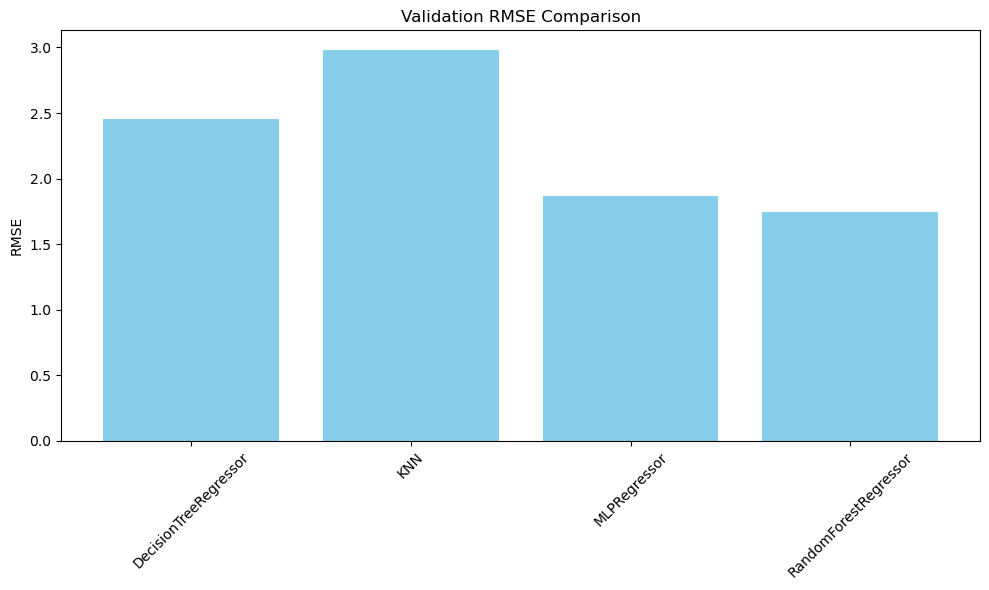

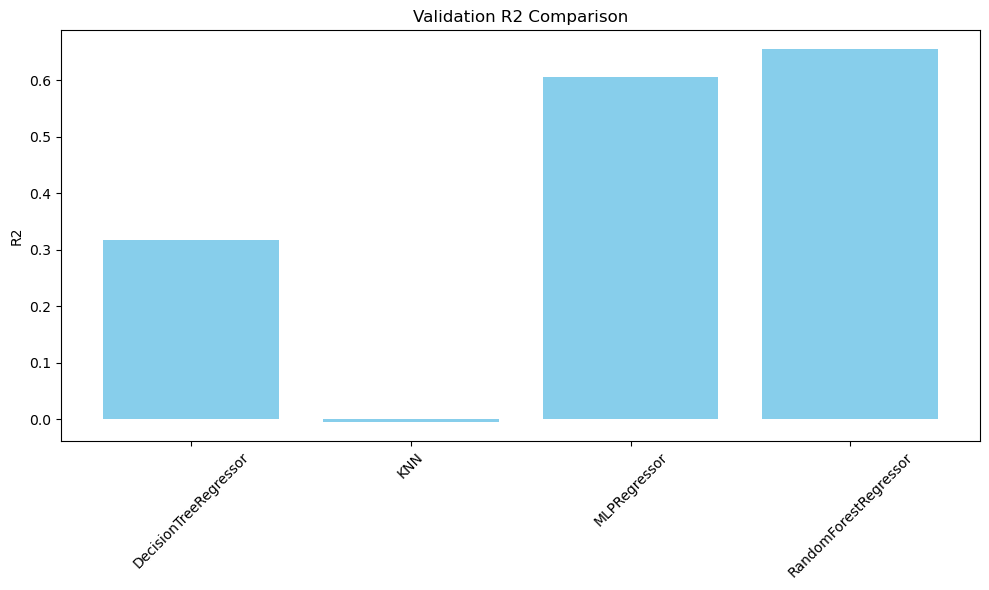

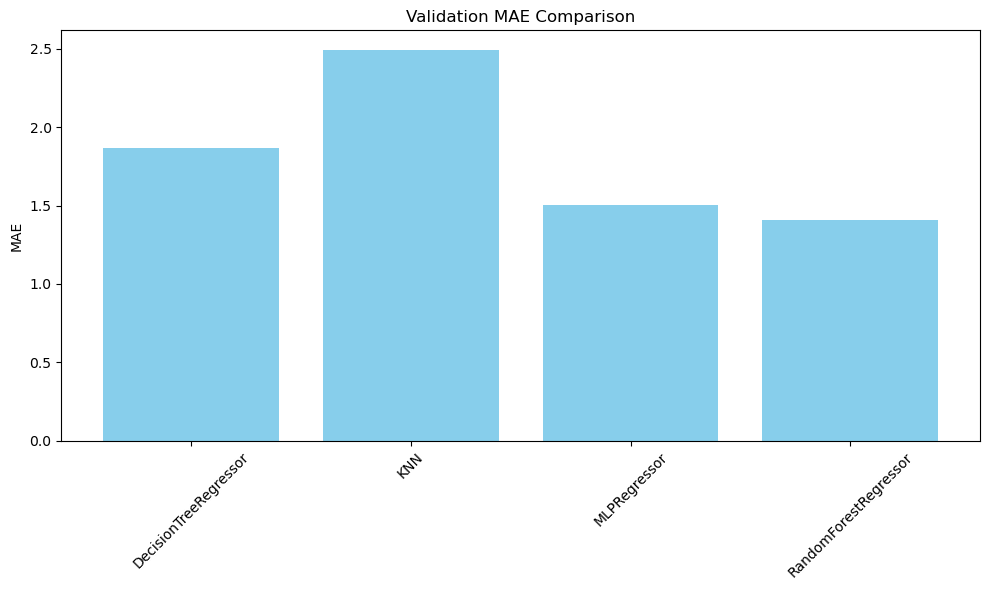

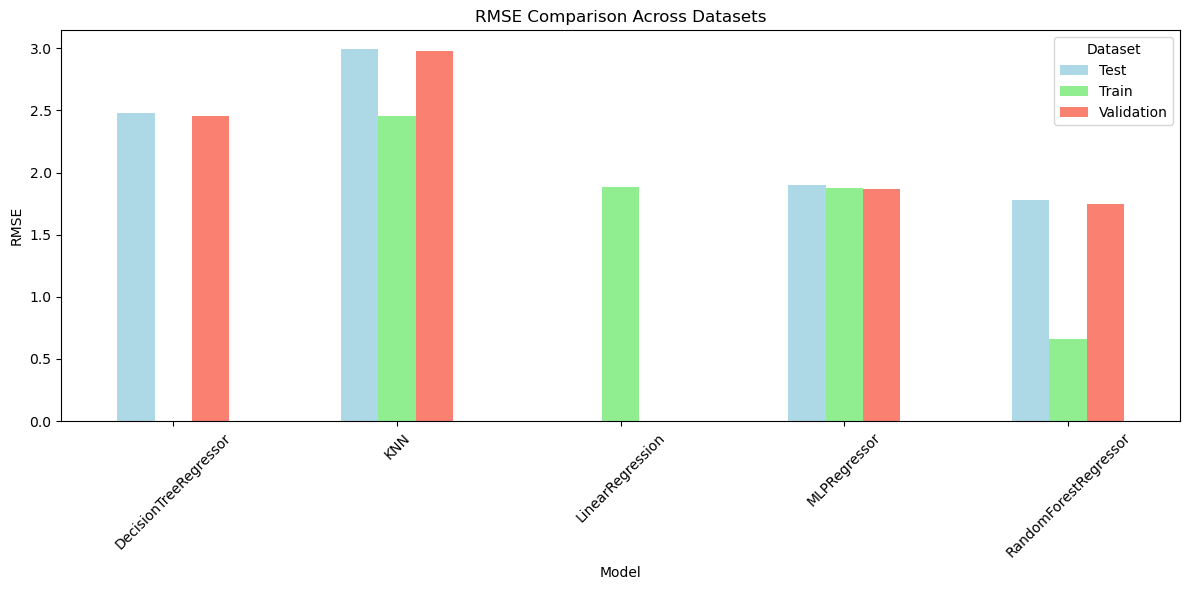

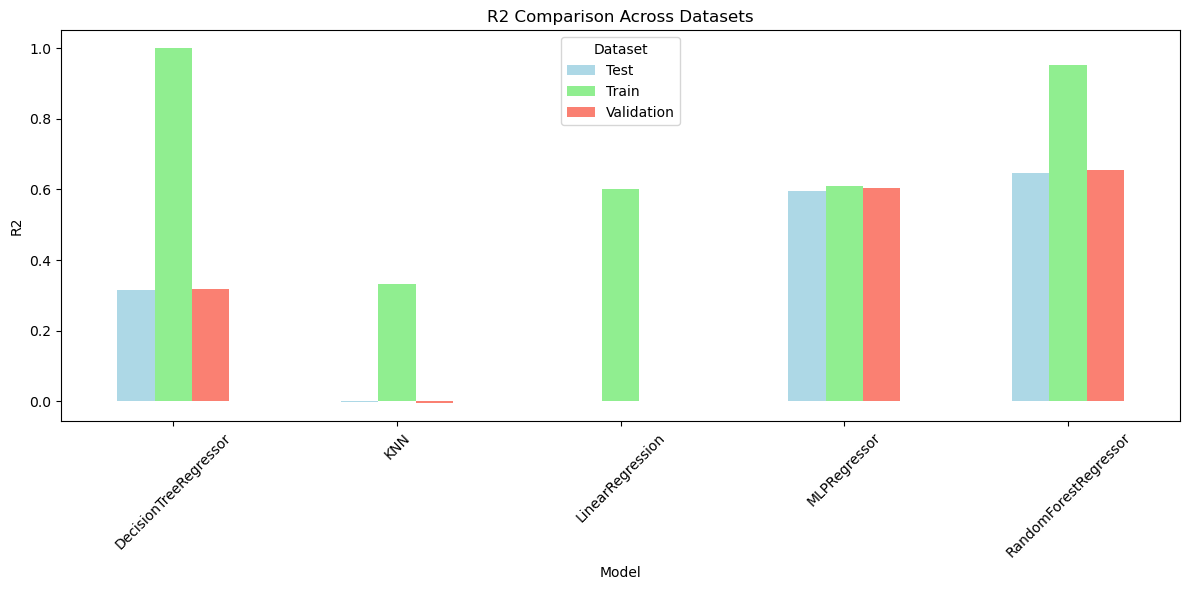

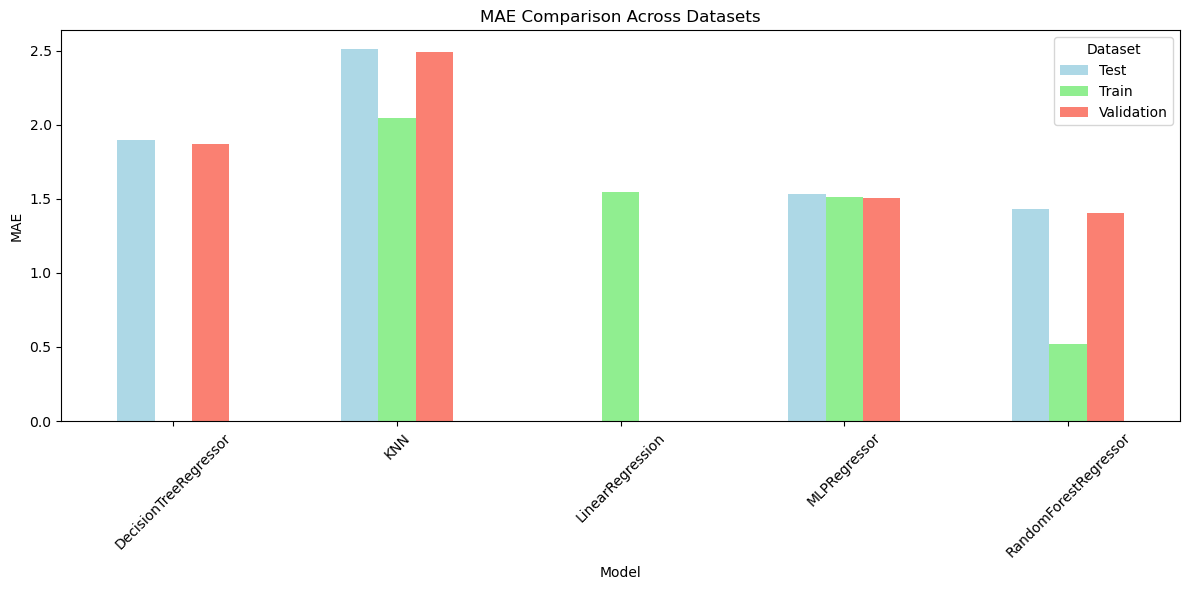


Test set comparison:
                     Model Dataset      RMSE        R2       MAE
2   RandomForestRegressor    Test  1.780322  0.646185  1.434370
5   DecisionTreeRegressor    Test  2.476053  0.315618  1.893762
8            MLPRegressor    Test  1.902607  0.595911  1.531645
11                    KNN    Test  2.995009 -0.001325  2.511507


In [71]:
# Model Selection & Visualization

# Focus on Validation dataset for model selection
val_results = all_results[all_results["Dataset"] == "Validation"]

# Select best model: lowest RMSE (you can also add highest R2 check if needed)
best_model = val_results.loc[val_results["RMSE"].idxmin()]
print("Best model based on Validation RMSE:\n", best_model)

# --- Visualization: Compare Validation metrics ---
for metric in ["RMSE","R2","MAE"]:
    plt.figure(figsize=(10,6))
    pivot = val_results.pivot_table(index="Model", columns="Dataset", values=metric, aggfunc="mean")
    plt.bar(pivot.index, pivot["Validation"], color="skyblue")
    plt.title(f"Validation {metric} Comparison")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"validation_{metric}_comparison.png"))
    plt.show()

# --- Extended Visualization: Compare Train vs Validation vs Test ---
for metric in ["RMSE","R2","MAE"]:
    pivot = all_results.pivot_table(index="Model", columns="Dataset", values=metric, aggfunc="mean")
    pivot.plot(kind="bar", figsize=(12,6), color=["lightblue","lightgreen","salmon"])
    plt.title(f"{metric} Comparison Across Datasets")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"all_datasets_{metric}_comparison.png"))
    plt.show()

# --- Further Assessment: Test set comparison ---
test_results = all_results[all_results["Dataset"]=="Test"]
print("\nTest set comparison:\n", test_results)

# Save test results table
test_results.to_csv(os.path.join(OUT_DIR, "test_set_results.csv"), index=False)


In [ ]:
Note: Random Forest is your strongest candidate — stable, interpretable, and generalizes well.
        Decision Tree is overfitting badly.
        MLP could improve with tuning but is less interpretable.
        Residual analysis + SHAP/LIME give you confidence in bias and feature contributions.